In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
# DSP data
fpath = "../../data/DNN_data/"

sig = np.load(fpath + "data_signal" + ".npy")
artifact = np.load(fpath + "data_sine_wave" + ".npy")
sig_with_artifact = np.load(fpath + "data_signal_with_sine" + ".npy")

sig_with_artifact.shape


(4000, 2)

Text(0.5, 1.0, 'Original Signal')

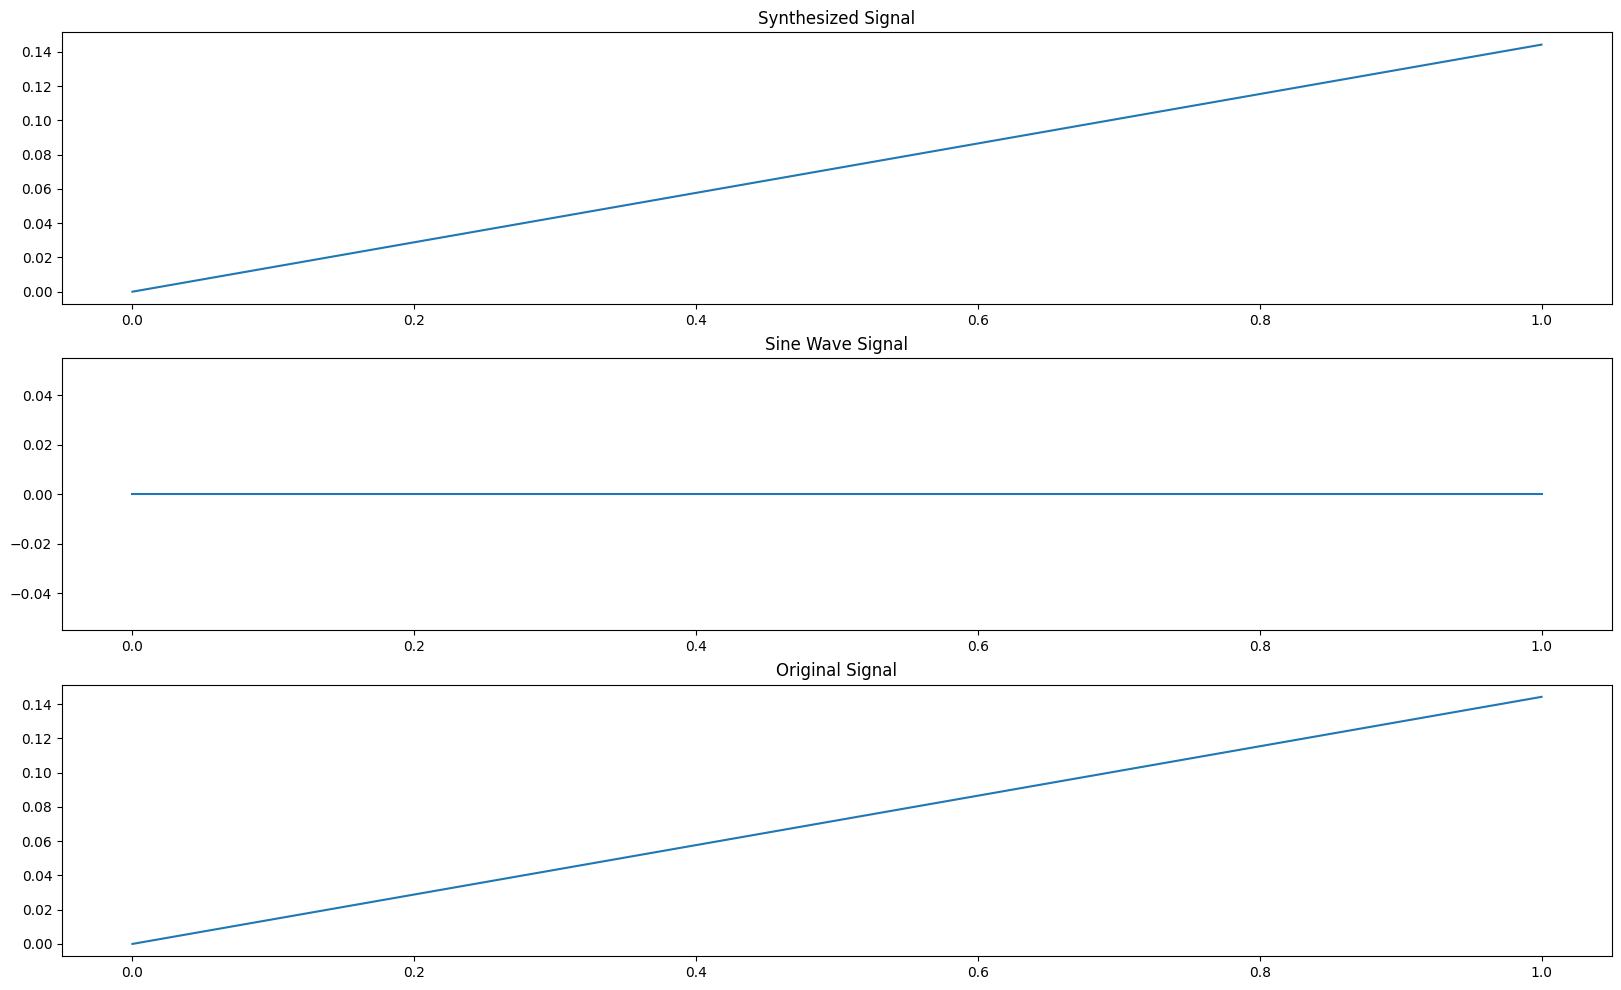

In [8]:
plt.figure(figsize=(20,12))
plt.subplot(3, 1, 1)
plt.plot(sig_with_artifact[:])
plt.title('Synthesized Signal')

plt.subplot(3, 1, 2)
plt.plot(artifact[:])
plt.title('Sine Wave Signal')

plt.subplot(3, 1, 3)
plt.plot(sig[:])
plt.title('Original Signal')

In [ ]:
# 데이터 통합 (열 단위로 concat)
#df_combined = pd.concat([data1, data2, data3], axis=1)

# sine 없이
df_combined = pd.concat([data1, data3], axis=1).transpose()

df_combined

In [ ]:
# 정규화
scaler = MinMaxScaler()
df_combined_scaled = scaler.fit_transform(df_combined)

df_combined_scaled.shape

# 추가
# df_combined_scaled = df_combined_scaled.transpose()

df_combined_scaled.shape

In [ ]:
# 입력과 출력 정의
num_samples = 4000
num_signals = 1000

# X = df_combined_scaled[:, :2*num_signals].reshape(num_samples, num_signals, 2)  # (4000, 1000, 2)
# y = df_combined_scaled[:, 2*num_signals:].reshape(num_samples, num_signals, 1)  # (4000, 1000, 1)

X = df_combined_scaled[:1000, :].reshape(1000, 4000, 1)
y = df_combined_scaled[1000:, :].reshape(1000, 4000, 1)

X.shape, y.shape

In [ ]:
# X_train = torch.tensor(X[:,:800,:], dtype=torch.float32).to(device)
# y_train = torch.tensor(y[:,:800,:], dtype=torch.float32).to(device)
# X_val = torch.tensor(X[:,800:1000,:], dtype=torch.float32).to(device)
# y_val = torch.tensor(y[:,800:1000,:], dtype=torch.float32).to(device)

# 훈련 세트와 검증 세트로 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# PyTorch Tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

# X_train_tensors = Variable(torch.Tensor(X_train))
# X_test_tensors = Variable(torch.Tensor(X_val))

# y_train_tensors = Variable(torch.Tensor(y_train))
# y_test_tensors = Variable(torch.Tensor(y_val))

X_train.shape, y_train.shape

In [ ]:
# LSTM 모델 정의
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes # 클래스 개수
        self.num_layers = num_layers # LSTM 계층의 개수
        self.input_size = input_size # 입력 크기로 훈련 데이터셋의 칼럼 개수를 의미
        self.hidden_size = hidden_size # hidden layer의 뉴런 개수
        self.seq_length = seq_length # 시퀀스 길이

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) # LSTM 계층
        self.fc_1 =  nn.Linear(hidden_size, 128) # 완전연결층
        self.fc = nn.Linear(128, num_classes) # 출력층

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 셀 상태를 0으로 초기화
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        output = output.reshape(-1, self.hidden_size) # fc layer 적용을 위해 데이터를 1차원 형태로 조정
        out = self.relu(output)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out)
        return out

In [ ]:
# 모델 인스턴스 생성
input_size = 1  # 입력 크기 (sine wave와 synthesized 신호)
hidden_size = 16  # 임의의 hidden layer 크기
num_layers = 2  # 임의의 LSTM layer 개수
num_classes = 1  # 출력 크기 (original 신호)
seq_length = num_samples  # 시퀀스 길이 (4000)

model = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length).to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# batch_size = 32
# X_batch = X_train[:batch_size].to(device)
# y_batch = y_train[:batch_size].to(device)
# outputs = model(X_batch).to(device)
# loss = criterion(outputs, y_batch.view(-1, num_classes))
# print('X_batch size: ', X_batch.size())
# print('y_batch size: ', y_batch.size())
# print('output size:', outputs.size())
# print('y_batch.view: ', y_batch.view(-1, num_classes).size())

In [ ]:
# 모델 훈련
num_epochs = 50
batch_size = 50

for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size].to(device)
        y_batch = y_train[i:i+batch_size].to(device)
        
        # Forward pass
        outputs = model(X_batch).to(device)
        optimizer.zero_grad()
        
        # Calculate loss
        loss = criterion(outputs, y_batch.view(-1, num_classes))
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    if epoch%1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# 모델 평가
model.eval()
with torch.no_grad():
    val_outputs = model(X_val)
    val_loss = criterion(val_outputs, y_val.view(-1, num_classes))
    print(f'Validation Loss: {val_loss.item():.4f}')


In [ ]:
# 검증 데이터 중 첫 번째 샘플에 대한 예측과 실제 값을 플롯
val_outputs = val_outputs.view(-1, num_signals, num_classes)  # reshape to (batch_size, seq_length, num_classes)
y_val = y_val.view(-1, num_signals, num_classes)
print(y_val.shape)

# 첫 번째 샘플의 첫 번째 신호만 선택하여 플롯 (여러 신호 중 하나만 플롯하는 예시)
sample_idx = 0
signal_idx = 0

predicted_signal = val_outputs[sample_idx, :, signal_idx].cpu().numpy()
actual_signal = y_val[sample_idx, :, signal_idx].cpu().numpy()

# 타임 스텝을 시간 단위로 변환
time_steps = np.linspace(0, 2, num=num_signals)  # 2초 동안 1000개의 샘플

plt.figure(figsize=(20, 16))
plt.subplot(3, 1, 1)
plt.plot(time_steps, predicted_signal, label='Predicted Signal')
plt.plot(time_steps, actual_signal, label='Actual Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Predicted vs Actual Signal')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_steps, actual_signal)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Actual Signal')

plt.subplot(3, 1, 3)
plt.plot(time_steps, predicted_signal)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Predicted Signal')

plt.show()


In [ ]:
n = len(predicted_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(predicted_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power1 = fft_predicted**2

fft_actual = np.fft.fft(actual_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power2 = fft_actual**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.log10(power1), label='Non-Filtered Signal', color='blue')
plt.plot(freqs, np.log10(power2), label='Filtered Signal', color='red')
plt.title('Power Spectrum of Non-Filtered and Filtered Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()